## Section 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import optimize
import batman

JDs = []
flux_norm = []
flux_norm_err = []

with open('section_4_5.csv', 'r') as file:
    reader = csv.reader(file)
    header = []
    header = next(reader)

    for row in reader:
        JDs.append(float(row[0]))
        flux_norm.append(float(row[6]))
        flux_norm_err.append(float(row[7]))


Powell Method

Mid Transit Time:       1.25551 hours
Period:                 1.81661 hours
Planet Radius (model):  1.69418 Solar Radii
Transit Depth:          0.02972
Planet Radius:          1.67772 Jupiter Radii
Transit Start:          0.91603 hours
Transit Stop:           1.59849 hours
Transit Duration:       0.68245 hours

These values were calculated with our data near the calculated mid transit. 
Since it is 'data informed' it should be more representative of our data:

Transit Depth: 0.0249950068 +/- 0.0039821438
Planet Radius: 1.5384778307 +/- 0.1256430896 Jupiter Radii


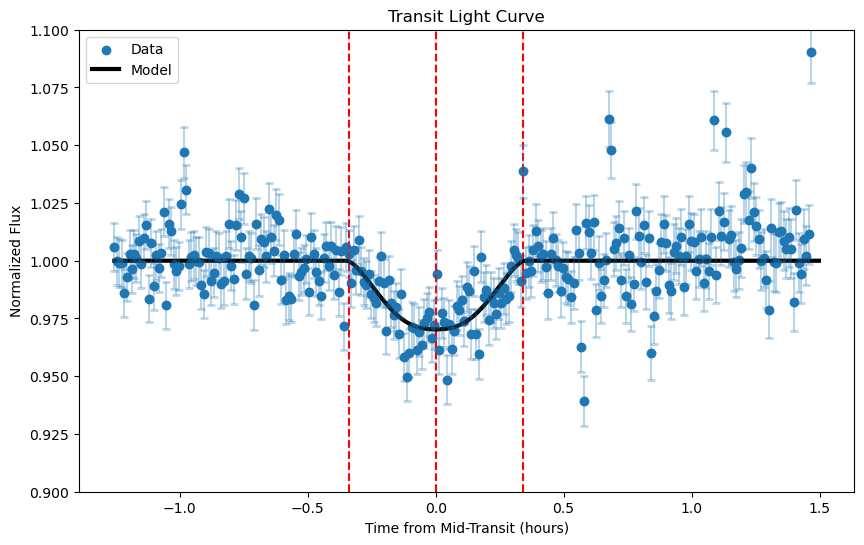

In [3]:
time = np.asarray(JDs)-JDs[0]

def chi_squared(params):
    t0, per, rp, a, inc, ecc, w, u1, u2 = params
    
    # Transit parameters
    transit_params = batman.TransitParams()
    transit_params.t0 = t0
    transit_params.per = per
    transit_params.rp = rp
    transit_params.a = a
    transit_params.inc = inc
    transit_params.ecc = ecc
    transit_params.w = w
    transit_params.u = [u1, u2]
    transit_params.limb_dark = "quadratic"
    
    # Transit model
    transit_model = batman.TransitModel(transit_params, time)
    model_flux = transit_model.light_curve(transit_params)

    # Calculate sum of squared differences
    return np.sum((flux_norm - model_flux)**2 / model_flux)

# Initial guess for parameters
initial_guess = [0.05, 0.5, 0.1, 15.0, 87.0, 0.0, 90.0, 0.1, 0.3]


sigs = []

# Minimize squared difference to converge to parameters
result = optimize.minimize(chi_squared, initial_guess, method="Powell")

# Extract the parameters
optimized_params = result.x

# Plot observed data and model
transit_params = batman.TransitParams()
transit_params.t0 = optimized_params[0]
transit_params.per = optimized_params[1]
transit_params.rp = optimized_params[2]
transit_params.a = optimized_params[3]
transit_params.inc = optimized_params[4]
transit_params.ecc = optimized_params[5]
transit_params.w = optimized_params[6]
transit_params.u = [optimized_params[7], optimized_params[8]]
transit_params.limb_dark = "quadratic"

transit_model = batman.TransitModel(transit_params, time)
model_flux = transit_model.light_curve(transit_params)

# Print optimized parameters
print("Powell Method\n")
print(f"Mid Transit Time:       {optimized_params[0]*24:.5f} hours")
print(f"Period:                 {optimized_params[1]:.5f} hours")
print(f"Planet Radius (model):  {optimized_params[2]*9.73116:.5f} Solar Radii")
print(f"Transit Depth:          {1.-np.min(model_flux):.5f}")
print(f"Planet Radius:          {np.sqrt(1-np.min(model_flux)) * 9.73116 * 1.000:.5f} Jupiter Radii")
    
plt.figure(figsize=(10, 6))
for i in range(0, len(model_flux)):
    if model_flux[i] != 1.0:
        plt.axvline((time[i] - transit_params.t0)*24, c='r', linestyle='--')
        transit_start = time[i]
        break
for i in range(len(model_flux)-1, 0, -1):
    if model_flux[i] != 1.0:
        plt.axvline((time[i] - transit_params.t0)*24, c='r', linestyle='--')
        transit_stop = time[i]
        break
            
print(f"Transit Start:          {transit_start * 24:.5f} hours")
print(f"Transit Stop:           {transit_stop * 24:.5f} hours")
print(f"Transit Duration:       {(transit_stop-transit_start) * 24:.5f} hours")

centered_time = np.asarray(time - optimized_params[0]) * 24
plt.axvline(0.0, c='r', linestyle='--')
plt.scatter(centered_time, flux_norm, label='Data')
plt.plot(centered_time, model_flux, c='black', label='Model', linewidth=3)
plt.ylim(0.9, 1.1)
plt.xlabel('Time from Mid-Transit (hours)')
plt.ylabel('Normalized Flux')
plt.title('Transit Light Curve')
    
#------------------------------------------------
sigma_var = []
sigma_stat = []

for i in range(0, int(len(flux_norm) / 10)+1):
    start = 10 * i
    end = 10*(i+1)
    mult = 10
    if 10*(i+1) > len(flux_norm):
        end = len(flux_norm)
        mult = end-start

#     variance = np.var(flux_norm[start:end])
    variance = np.sum((flux_norm[start:end] - model_flux[start:end])**2) / (len(flux_norm[start:end])-1)
    uncert = np.mean(flux_norm_err[start:end])
    nums = [variance]*mult
    uncerts = [uncert]*mult
    for value in nums:
        sigma_var.append(value)
    for unc in uncerts:
        sigma_stat.append(unc)
        
sigs.append(sigma_var)
sigma_sys = np.sqrt(np.abs(np.asarray(sigma_var)**2 - np.asarray(sigma_stat)**2))
sigma_tot = np.sqrt(np.asarray(flux_norm_err)**2 + sigma_sys**2)
sigma_mean = sigma_tot / np.sqrt(len(flux_norm))

t0 = optimized_params[0]

for i in range(0, len(time)):
    if time[i] < t0 and time[i+1] > t0:
        mid_start = i-3
        mid_end = i+4
        mid_flux = flux_norm[mid_start:mid_end]
        mid_time = time[mid_start:mid_end]
        mid_model_flux = model_flux[mid_start:mid_end]

mid_var = np.sum((np.asarray(mid_flux) - np.asarray(mid_model_flux))**2) / (len(mid_flux)-1)
mid_sigma_sys = np.sqrt(np.abs(np.asarray(mid_var)**2 - np.asarray(sigma_stat[mid_start:mid_end])**2))
mid_sigma_tot = np.sqrt(np.asarray(flux_norm_err[mid_start:mid_end])**2 + mid_sigma_sys**2)
mid_sigma = mid_sigma_tot[3] / np.sqrt(len(mid_flux))
mid_flux_value = np.sum(mid_flux) / len(mid_flux)

depth = 1-mid_flux_value
planet_radius = np.sqrt(depth) * 9.73116
depth_x_rad_err = depth * np.sqrt(0.036**2 + (mid_sigma / depth)**2) * 9.73116
rad_err = 0.5 * depth**(-0.5) * depth_x_rad_err

print(f"\nThese values were calculated with our data near the calculated mid transit. \nSince it is 'data informed' it should be more representative of our data:\n")
print(f"Transit Depth: {depth:.10f} +/- {mid_sigma:.10f}")
print(f"Planet Radius: {planet_radius:.10f} +/- {rad_err:.10f} Jupiter Radii")

plt.errorbar(centered_time, flux_norm, yerr=sigma_tot, capsize=3, capthick=2, fmt='o', alpha=0.3)
# plt.scatter(mid_time - t0, mid_flux, c='r')
plt.legend()
plt.show()